In [49]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from reproject import reproject_interp
from astropy import stats
from astropy.io import fits
from astropy.table import join
from glob import glob 
import sys
import os

sys.path.append('./../')
from modules import dendro_dendro, dendro_misc, dendro_props, dendro_mask

In [50]:
# Define names and filenames...

galaxy = 'ic5332'
galaxy_hst = galaxy
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'

hstha_file = '%s/data_hstha/%s/hst_contsub/%s_hst_ha_sic.fits' %(root_dir, galaxy_hst, galaxy_hst)
muscat_file = '%s/data_hstha/%s/muse/%s_nebmask.fits' %(root_dir, galaxy_hst, galaxy.upper())
musha_file = '%s/data_hstha/%s/muse/%s-*_MAPS.fits' %(root_dir, galaxy_hst, galaxy.upper())
musha_file = glob(musha_file)[0] #because of resolution in name

cutout_dir = '%s/data_hstha_nebulae_catalogue/%s/cutouts' %(root_dir, galaxy_hst)
dendro_dir = '%s/data_hstha_nebulae_catalogue/%s/dendro' %(root_dir, galaxy_hst)
cutouts_hdus_dir = '%s/data_hstha_nebulae_catalogue/%s/cutouts_hdus' %(root_dir, galaxy_hst)

rerun_all = False
rerun_masking = False

regions_file = '%s/sample.reg' %cutout_dir
regions_pickel_file = '%s/sample.pickel' %cutout_dir
sample_table_file = '%s/data_misc/sample_table/phangs_sample_table_v1p6.fits' %root_dir
muscat_table_file = '%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir

print(hstha_file)
print(muscat_file)
print(musha_file)
print(cutout_dir)
print(dendro_dir)
print(cutouts_hdus_dir)
print(regions_file)
print(regions_pickel_file)
print(sample_table_file)
print(muscat_table_file)

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/hst_contsub/ic5332_hst_ha_sic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/muse/IC5332_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/muse/IC5332-0.87asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/dendro
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts_hdus
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/sample.reg
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/sample.pickel
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/sample_table/phangs_sample_table_v1p6.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/Nebulae_catalogue_v3/Nebulae_cata

In [51]:
from modules.dendro_dendro import *

In [52]:
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, join, vstack
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from reproject import reproject_interp

import astropy.units as au
from astropy import stats
from astrodendro import Dendrogram, pp_catalog
from astropy.wcs import WCS
from astropy.table import Column

from astropy.io import fits
import aplpy
from tqdm.auto import tqdm

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.ndimage import binary_dilation

from astropy.wcs import WCS

def get_dedro(hdu, hdu_outmask, hdu_nomask, sampletable, min_npix=9, min_value_sig=3, min_delta_sig=3, std=None):
    """
    Perform dendrogram analysis on the input data and extract properties of the identified structures.
    
    Parameters:
        hdu (HDU): Input data HDU.
        hdu_outmask (HDU): Output mask HDU.
        hdu_nomask (HDU): Non-masked data HDU.
        min_npix (int, optional): Minimum number of pixels within a structure. Defaults to 9.
        min_value_sig (int, optional): Minimum value within a structure in terms of standard deviation. Defaults to 3.
        min_delta_sig (int, optional): Minimum values between levels within a structure in terms of standard deviation. Defaults to 3.
    
    Returns:
        tuple: A tuple containing the following:
            - dendro (Dendrogram): The computed dendrogram.
            - props (Table): Properties of the identified structure.
            - indexmap_trunk_hdu (HDU): Index map of the trunk structure.
            - indexmap_trunk_close_hdu (HDU): Index map of the trunk structure with closing operation applied.
    """

    # Replace variable names with appropriate names
    wcs = WCS(hdu.header)
    header = hdu.header

    data = hdu.data
    data_nomask = hdu_nomask.data
    data_outmask = hdu_outmask.data

    # Calculate statistics for dendrogram
    if std is None: 

        # print('Calculating rms for indv. fields')
        std = stats.mad_std(data_outmask, ignore_nan=True)  # Get noise
        std = stats.mad_std(data_outmask[data_outmask<20*std], ignore_nan=True)  # Get noise below threshold

    try:
        pixsize = np.array([np.abs(header['CDELT1']), np.abs(header['CDELT2'])]).mean() * au.degree
    except: 
        pixsize = np.array([np.abs(header['CD1_1']), np.abs(header['CD2_2'])]).mean() * au.degree

    if pixsize.value==1: 
        if 'CD1_1' in np.array(header.cards)[:,0]: 
            pixsize = np.array([np.abs(header['CD1_1']), np.abs(header['CD2_2'])]).mean() * au.degree
        elif 'PC1_1' in np.array(header.cards)[:,0]:
            pixsize = np.array([np.abs(header['PC1_1']), np.abs(header['PC2_2'])]).mean() * au.degree

    bmaj = bmin = 0.05 * au.arcsec  # Dummy values 

    min_value = std * min_value_sig  # Minimum value within structure
    min_delta = std * min_delta_sig  # Minimum values between levels within structure (sort of)

    # Running the dendrogram
    dendro = Dendrogram.compute(data,
                                min_delta=min_delta,
                                min_value=min_value,
                                min_npix=min_npix,
                                wcs=wcs)

    # Provide metadata for table output
    metadata = {}
    metadata['data_unit'] = au.Jy / au.beam  # Dummy unit
    metadata['spatial_scale'] = pixsize.to('arcsec')
    metadata['beam_major'] = bmaj.to('arcsec')
    metadata['beam_minor'] = bmin.to('arcsec')

    # Check if the dendrogram has more than one structure
    if len(np.unique(dendro.index_map)) != 1: 
        # Compute properties of the identified structures
        props = pp_catalog(dendro, metadata, verbose=False)  # Get table
        
        # Check if the maximum flux is zero
        if np.nanmax(props['flux'].value) == 0: 
            print('Zero flux found...') 
            return([None] * 4)
    
    else: 
        return([None] * 4)

    indexmap = dendro.index_map  # Get index map
    indexmap_hdu = fits.PrimaryHDU(indexmap, header)
    indexmap_hdu.data = np.array(indexmap_hdu.data, dtype=float)
    indexmap_hdu.data[indexmap_hdu.data == -1] = np.nan

    indexmap_trunk = get_trunkindexmap(dendro)
    indexmap_trunk_hdu = fits.PrimaryHDU(indexmap_trunk, header)
    indexmap_trunk_hdu.data = np.array(indexmap_trunk_hdu.data, dtype=float)

    props_trunk = pp_catalog(dendro.trunk, metadata, verbose=False)  # Get table
    
    # Get the ID of the structure with maximum flux
    arg = np.argmax(props_trunk['flux'])
    midpix_id = props_trunk['_idx'][arg]

    # Remove all other structures from the catalogue
    indexmap_trunk_hdu.data[indexmap_trunk_hdu.data != midpix_id] = -1
    props = props[props['_idx'] == midpix_id]

    # Get single trunk index map
    idx = np.unique(indexmap_trunk_hdu.data[indexmap_trunk_hdu.data != -1])
    mask = indexmap_trunk_hdu.data != -1
    mask1 = scipy.ndimage.binary_closing(mask, iterations=10) * 1
    mask1[mask1 != 1.0] = -1.
    mask1[mask1 == 1.0] = idx
    indexmap_trunk_close = np.copy(mask1)
    indexmap_trunk_close_hdu = fits.PrimaryHDU(indexmap_trunk_close, indexmap_trunk_hdu.header)

    radius_trunk = get_circrad(indexmap_trunk_hdu.data, pixsize)
    radius_trunkclose = get_circrad(indexmap_trunk_close_hdu.data, pixsize)

    # Add properties to table    
    props['radius_trunk'] = radius_trunk
    props['radius_trunkclose'] = radius_trunkclose
    props['major_fwtm'] = props['major_sigma'] * 4.292
    props['minor_fwtm'] = props['minor_sigma'] * 4.292
    props['mean_fwtm'] = np.nanmean([props['major_fwtm'], props['minor_fwtm']]) * props['major_fwtm'].unit
    props['mean_hwtm'] = props['mean_fwtm'] / 2.
    
    props['major_fwhm'] = props['major_sigma'] * 2*np.sqrt(2*np.log(2))
    props['minor_fwhm'] = props['minor_sigma'] * 2*np.sqrt(2*np.log(2))
    props['mean_fwhm'] = np.nanmean([props['major_fwhm'], props['minor_fwhm']]) * props['major_fwhm'].unit
    props['mean_hwhm'] = props['mean_fwhm'] / 2.

    props['min_npix'] = min_npix
    props['min_value_sig'] = min_value_sig
    props['min_delta_sig'] = min_delta_sig
    
    # Convert to parcsec
    pcperarcsec = get_pcperarcsec(sampletable)
    props['radius_trunk_pc'] = props['radius_trunk'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['radius_trunkclose_pc'] = props['radius_trunkclose'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['major_fwtm_pc'] = props['major_fwtm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['minor_fwtm_pc'] = props['minor_fwtm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['mean_fwtm_pc'] = props['mean_fwtm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['mean_hwtm_pc'] = props['mean_fwtm_pc'] / 2.

    props['major_fwhm_pc'] = props['major_fwhm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['minor_fwhm_pc'] = props['minor_fwhm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['mean_fwhm_pc'] = props['mean_fwhm'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    props['mean_hwhm_pc'] = props['mean_fwhm_pc'] / 2.

    # Get max x,y positions
    mask = indexmap_trunk_close_hdu.data.copy() == -1
    data[mask] = 0
    y_max, x_max = np.where(data==np.nanmax(data))

    ax = aplpy.FITSFigure(hdu)
    ra_struc = ax.pixel2world(props['x_cen'], props['y_cen'])[0][0]
    dec_struc = ax.pixel2world(props['x_cen'], props['y_cen'])[1][0]
    ra_max = ax.pixel2world(x_max, y_max)[0][0]
    dec_max = ax.pixel2world(x_max, y_max)[1][0]
    plt.close('all')

    props['ra_cen'] = ra_struc * au.deg
    props['dec_cen'] = dec_struc * au.deg
    props.rename_column('radius', 'mean_sigma')
    props['mean_sigma_pc'] = props['mean_sigma'].quantity[0].to('arcsec').value * pcperarcsec * au.pc
    
    props['x_max'] = x_max *props['x_cen'].unit
    props['y_max'] = y_max *props['x_cen'].unit
    props['ra_max'] = ra_max *au.deg
    props['dec_max'] = dec_max *au.deg

    flux = np.nansum(hdu.data[indexmap_trunk_close_hdu.data != -1])
    props['flux'] = flux
    props['flux'].unit = au.erg / au.s / au.cm**2

    props['npix'] = np.nansum(mask1!=-1)
    props['flux_err'] = np.sqrt(props['npix'])*std
    props['flux_err'].unit = props['flux'].unit

    props = Table(props, masked=True, copy=False)

    return dendro, props, indexmap_trunk_hdu, indexmap_trunk_close_hdu


def get_dedro_all(hdus, sampletable, muscat_regionIDs, min_npix=9, min_value_sig=3, min_delta_sig=3, std=None):
    
    props_all = []
    indexmap_trunk_hdu_all = []
    indexmap_trunk_close_hdu_all = []
    first_no_found_run = 0

    for i in tqdm(range(len(muscat_regionIDs)), desc='Dendrogram', position=0):

        # if i >5: 
        #     continue
        
        muscat_regionID = muscat_regionIDs[i]

        if not all_nan_check(hdus, i): 

            output = get_dedro(hdus['hstha_hdu_smooth_masked'][i],
                                hdus['hstha_hdu_smooth_maskedall'][i], 
                                hdus['hstha_hdu_smooth'][i],
                                sampletable=sampletable,
                                min_npix=min_npix, 
                                min_value_sig=min_value_sig, 
                                min_delta_sig=min_delta_sig, 
                                std=std)

            dendro, props, indexmap_trunk_hdu, indexmap_trunk_close_hdu = output

            try:
                # Change index to MUSE indexing in indexmaps
                indexmap_trunk_hdu.data[indexmap_trunk_hdu.data!=-1] = muscat_regionID
                indexmap_trunk_close_hdu.data[indexmap_trunk_close_hdu.data!=-1] = muscat_regionID
            except:
                print(f'[INFO] [get_dedro] [regionID={muscat_regionID}] No dendro found...')
                None
        else: 
            print(f'[INFO] [get_dedro] [regionID={muscat_regionID}] No dendro found, all nan values...')
            props = None
        
        # Replace values when no region is found due to all nans or other
        if props is None: 

            # Only run this one once...
            # Replace values with some dummy dendro table so we have all the correct columns, will be masked later anyway... 
            if first_no_found_run == 0: 
                first_no_found_run = 1
                
                print(f'[INFO] [get_dedro] Running dummy dendro...')
                j=0
                while props is None: 

                    j+=1 
                    output_ = get_dedro(hdus['hstha_hdu_smooth_masked'][j],
                                        hdus['hstha_hdu_smooth_maskedall'][j], 
                                        hdus['hstha_hdu_smooth'][j],
                                        sampletable=sampletable,
                                        min_npix=0, 
                                        min_value_sig=-100, 
                                        min_delta_sig=-100, 
                                        std=std)
                    
                    dendro, props_, indexmap_trunk_hdu, indexmap_trunk_close_hdu = output_
                    
                    if props_ is not None:
                        props = props_.copy()
                    else:
                        props = None
                    
            else:           
                dendro, props, indexmap_trunk_hdu, indexmap_trunk_close_hdu = output_
                props = props_.copy()

            for colname in props.colnames: 
                props[colname] = np.ma.masked

            # Blanks array in index map if nothing is found 
            shape = indexmap_trunk_hdu.data.shape
            header = indexmap_trunk_hdu.header
            indexmap_trunk_hdu = fits.PrimaryHDU(np.ones(shape)*-1, header)
            indexmap_trunk_close_hdu = fits.PrimaryHDU(np.ones(shape)*-1, header)
        
        # Add good and masked to properties 
        props.add_column(Column(muscat_regionID, name='region_ID'), index=0)  
        props.add_column(Column(i, name='hstcat_region_ID'), index=1)

        # Edge flag
        flag_edge = np.isnan(hdus['hstha_hdu_smooth_masked_ones'][i].data).any()*1
        props.add_column(Column(flag_edge, name='flag_edge_hst')) 

        props_all += [props]
        indexmap_trunk_hdu_all += [indexmap_trunk_hdu]
        indexmap_trunk_close_hdu_all += [indexmap_trunk_close_hdu]

    props_all = vstack(props_all)
    hdus['indexmap_trunk_hdu'] = indexmap_trunk_hdu_all
    hdus['indexmap_trunk_close_hdu'] = indexmap_trunk_close_hdu_all

    return props_all, hdus


In [53]:
# Loading files...
hstha_hdu = fits.open(hstha_file)[0]
muscat_hdu = fits.open(muscat_file)[0]

hstha_hdu = dendro_misc.convert_to_float32(hstha_hdu)
muscat_hdu = dendro_misc.convert_to_float32(muscat_hdu)

# Update arrays
muscat_hdu.data = np.array(muscat_hdu.data, dtype=float)
muscat_hdu.data[muscat_hdu.data==-1] = np.nan

# Interpolate masks
muscat_data_re, _ = reproject_interp(muscat_hdu, hstha_hdu.header)
muscat_data_mask = ~np.isnan(muscat_data_re)
data_outmask = hstha_hdu.data[~muscat_data_mask]

# Get RMS for whole map... 
std = stats.mad_std(data_outmask, ignore_nan=True)  # Get noise
std = stats.mad_std(data_outmask[data_outmask<20*std], ignore_nan=True)  # Get noise below threshold

# Load regions, sample table and HDUs... 
hdus_cutouts = dendro_misc.load_pickle('%s/hdus_all.pickel' %cutout_dir)
regions = dendro_misc.load_pickle(regions_pickel_file)

sample_table = dendro_misc.get_galaxyprops(galaxy, sample_table_file)
muscat_table = dendro_misc.get_museprops(galaxy, muscat_table_file)

# Load cutout hdus with smoothed, masked, and non-masked data...
hdus_file = '%s/hdus_all_withmasked.pickel' %cutout_dir
muscat_regionIDs_file =  '%s/muscat_regionIDs.pickel' %cutout_dir

if os.path.exists(hdus_file) & ~rerun_masking:
    muscat_regionIDs = muscat_table['region_ID']
    hdus = dendro_misc.load_pickle(hdus_file)
else: 
    muscat_regionIDs = muscat_table['region_ID']
    hdus = dendro_dendro.get_maskedhdus(hdus_cutouts, regions, muscat_regionIDs)
    dendro_misc.save_pickle(hdus, hdus_file)

[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/hdus_all.pickel
[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/sample.pickel
[INFO] [get_galaxyprops] Getting sample table properties for ic5332...
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ic5332...
[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/hdus_all_withmasked.pickel


In [64]:
# Get dendrogram for all... 
# props_all, hdus = dendro_dendro.get_dedro_all(hdus, sample_table, muscat_regionIDs)
props_all, hdus = get_dedro_all(hdus, sample_table, muscat_regionIDs, min_npix=9, min_value_sig=3, min_delta_sig=3, std=std)

Dendrogram:   0%|          | 0/816 [00:00<?, ?it/s]

[INFO] [get_dedro] [regionID=1.0] No dendro found...
[INFO] [get_dedro] Running dummy dendro...
[INFO] [get_dedro] [regionID=2.0] No dendro found...
[INFO] [get_dedro] [regionID=4.0] No dendro found...
[INFO] [get_dedro] [regionID=5.0] No dendro found...
[INFO] [get_dedro] [regionID=6.0] No dendro found...
[INFO] [get_dedro] [regionID=8.0] No dendro found...
[INFO] [get_dedro] [regionID=9.0] No dendro found...
[INFO] [get_dedro] [regionID=13.0] No dendro found...
[INFO] [get_dedro] [regionID=14.0] No dendro found...
[INFO] [get_dedro] [regionID=16.0] No dendro found...
[INFO] [get_dedro] [regionID=18.0] No dendro found...
[INFO] [get_dedro] [regionID=20.0] No dendro found...
[INFO] [get_dedro] [regionID=21.0] No dendro found...
[INFO] [get_dedro] [regionID=22.0] No dendro found...
[INFO] [get_dedro] [regionID=23.0] No dendro found...
[INFO] [get_dedro] [regionID=24.0] No dendro found...
[INFO] [get_dedro] [regionID=25.0] No dendro found...
[INFO] [get_dedro] [regionID=27.0] No dendro f

In [65]:
props_all['flux']/props_all['flux_err'], props_all['npix']

(<MaskedColumn name='flux' dtype='float64' unit='erg / (s cm2)' length=816>
  17.50865835826832
                 --
                 --
 26.732093867494633
                 --
                 --
                 --
  80.73767882461877
                 --
                 --
  41.73031042358085
 26.118322025562247
                ...
                 --
                 --
                 --
                 --
                 --
                 --
                 --
                 --
                 --
                 --
                 --
                 --,
 <MaskedColumn name='npix' dtype='int64' length=816>
  21
  --
  --
  29
  --
  --
  --
  86
  --
  --
  58
  38
 ...
  --
  --
  --
  --
  --
  --
  --
  --
  --
  --
  --
  --)

In [66]:
# Add additional infomation from MUSE and save... 
props_all_muscat_table = join(props_all, muscat_table, keys='region_ID')
props_all_muscat_table['flux_corr'] = dendro_props.correct_ha_flux(props_all_muscat_table)
props_all_muscat_table['ha_lum_hst'] = dendro_props.calculate_luminosity(props_all_muscat_table['flux_corr']*1e-20, sample_table['dist'].quantity[0])   
props_all_muscat_table['region_circ_rad_pc'] = dendro_props.calculate_radius(props_all_muscat_table['region_circ_rad'], sample_table['dist'].quantity[0])  
props_all_muscat_table.rename_column('flux', 'HA6562_FLUX_HST')
props_all_muscat_table.rename_column('flux_corr', 'HA6562_FLUX_HST_CORR')
props_all_muscat_table.rename_column('ha_lum_hst', 'HA6562_LUMINOSITY_HST')

# dendro_misc.save_pickle(hdus, '%s/hdus_all_withmasked_withdendro.pickel' %dendro_dir)
# dendro_misc.save_pickle(props_all_muscat_table, '%s/props_all.pickel' %dendro_dir)        
# props_all_muscat_table.write('%s/props_all.fits' %dendro_dir, overwrite=True)

# # Save HDUs as HDU lists for each region with RegionID
# dendro_dendro.get_hdulists(hdus, muscat_regionIDs, outputdir=cutouts_hdus_dir)

# # Save region file of masks 
# dendro_mask.get_ds9regions_circ_decor(props_all, '%s/%s_trunk_regions.reg' %(dendro_dir, galaxy))
# dendro_mask.get_ds9regions_ellip_decor(props_all, '%s/%s_sigma_regions.reg' %(dendro_dir, galaxy))

# # Save the mask for whole mosaic
# hstha_hdu = fits.open(hstha_file)[0]
# dendro_mask.get_hdumask(hstha_hdu, hdus['indexmap_trunk_hdu'], '%s/%s_trunk_mask.fits'  %(dendro_dir, galaxy))
# dendro_mask.get_hdumask(hstha_hdu, hdus['indexmap_trunk_close_hdu'], '%s/%s_trunk_close_mask.fits'  %(dendro_dir, galaxy))

# # Save flags for when regions are touching
# hdu_mask = fits.open('%s/%s_trunk_mask.fits'  %(dendro_dir, galaxy))[0]
# props_all_muscat_table = dendro_dendro.get_flag_touch(props_all_muscat_table, hdu_mask)
# props_all_muscat_table.write('%s/props_all.fits' %dendro_dir, overwrite=True)

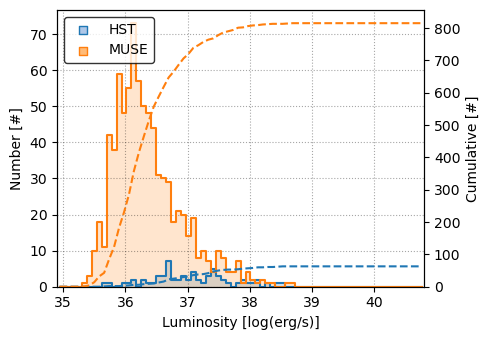

In [67]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
from astropy.table import QTable

# plt.style.use('paper.mplstyle')

def get_hist(data, bins=None, nbins=50, logbins=False, norm=True, cum=False):

    """Get histogram

    Parameters
    ----------
    data : np.array
        input data
    bins : list
        input bin edges for histogram calculaiton; default=''
    nbins : int
        number of bins to determine if bins is not given; defult=50
    logbins : bool
        logarithmically spaced bins if bins is not given
    norm : bool
        normalise such that max is equal to unity; default=True
    cum : bool
        cumulative distorbution; otherwise probability distorbution
    Returns
    -------
    bins : list
        bin edges for histogram calculaiton
    bin_cent : np.array
        bin centres, for easy plotting in matplotlib
    hist : np.array
        histogram data for each bin centre
    """

    data = data.flatten()

    if bins.all() is None:
        vmin=np.nanmin(data)
        vmax=np.nanmax(data)

        bmin = vmin - (np.absolute(vmin)*1)
        bmax = vmax + (np.absolute(vmax)*0.3)

        if logbins:
            min = np.nanmin(data[data>0])
            bins = np.logspace(np.log10(bmin), np.log10(bmax), nbins+1)
        else:
            bins = np.linspace(bmin, bmax, nbins+1)
    else:
        nbins = len(bins)-1

    bins_cent = np.empty([nbins])

    for i in range(nbins):
        bins_cent[i] = np.nanmean([bins[i], bins[i+1]])

    hist = np.histogram(data.flatten(), bins)[0]

    if cum:
        hist = np.cumsum(hist)
    if norm:
        hist = hist/np.nanmax(hist)

    return(bins, bins_cent, hist)

table = props_all_muscat_table

colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['Lum_HA6562_CORR'].value))

bins = np.linspace(34.9, 40.8, 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3.5)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid', c='C0')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='HST')

ax.plot(bins_cent2, hist2, ds='steps-mid', c='C1')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid', fc='C1')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='MUSE')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(np.percentile(bins, [0,100]))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Luminosity [log(erg/s)]')
ax.set_ylabel('Number [#]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum, ls='--', c='C1')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='upper left', edgecolor='black')

# plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')